### Import Libraries

In [ ]:
import os
import pickle
from tqdm import tqdm
# import umap
import collections

%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from IPython.display import Image

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.utils import load_img

pd.options.mode.chained_assignment = None  # default='warn'

2023-06-28 07:12:13.204974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Metadata

In [34]:
df = pd.read_json("../dataset/1.json")

In [38]:
df["char"] = df["data"].apply(lambda x: x["char"])
df["url"] = df["data"].apply(lambda x: "nii_project/" + x["url"][28:])
df.head(5)

data char   
0  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...   その  \
1  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    子   
2  {'char': 'むまこ', 'url': 'http://codh.rois.ac.jp...  むまこ   
3  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...  まては   
4  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...  はふれ   

                                   url image_file  
0  nii_project/dataset/1/0_001_0_1.jpg             
1  nii_project/dataset/1/1_001_0_1.jpg             
2  nii_project/dataset/1/2_001_0_1.jpg             
3  nii_project/dataset/1/3_001_0_1.jpg             
4  nii_project/dataset/1/4_001_0_1.jpg

In [42]:
df_count = (
    df.groupby("char").count().sort_values(by=["data"], ascending=False)[["data"]]
)

# single_char = [ele for ele in df_count.index if len(ele) == 1]
# df_single_char = df[df["char"].isin(single_char)]
# df_single_char.loc[:, "image_file"] = df_single_char["url"].apply(lambda x: x[48:])
df.loc[:, "image_file"] = df["url"].apply(lambda x: x[22:])

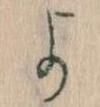

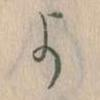

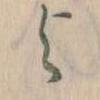

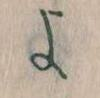

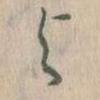

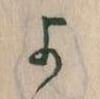

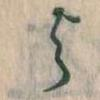

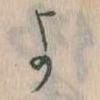

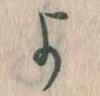

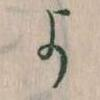

In [44]:
for url in df[df["char"] == "よ"].sample(10).url:
    display(Image(filename=url))

In [48]:
path = r"/fs9/yuxiao/nii_project/dataset/1"
# change the working directory to the path where the images are located
os.chdir(path)
# this list holds all the image filename
chars = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
    # loops through each file in the directory
    for file in files:
        if file.name.endswith(".jpg") and file.name in df["image_file"].values:
            # adds only the image files to the flowers list
            chars.append(file.name)

In [49]:
len(chars)

36880

### Binarization

In [50]:
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype("uint8")
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs, cmap="gray")

In [59]:
df.sample(1).url.values[0]

'nii_project/dataset/1/32756_001_82_0.jpg'

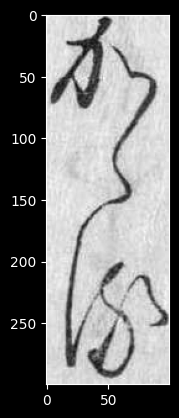

In [63]:
img = cv2.imread(PATH + df.sample(1).url.values[0])

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2_imshow(img)

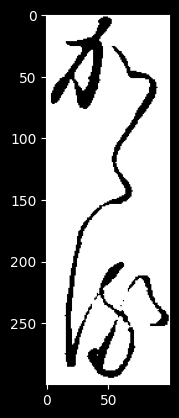

In [64]:
_, dst1 = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
cv2_imshow(dst1)

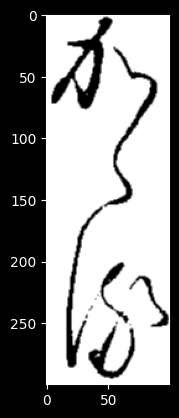

In [65]:
dst2 = cv2.adaptiveThreshold(
    img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 301, 50
)
blur = cv2.blur(dst2, (2, 2))
cv2_imshow(blur)

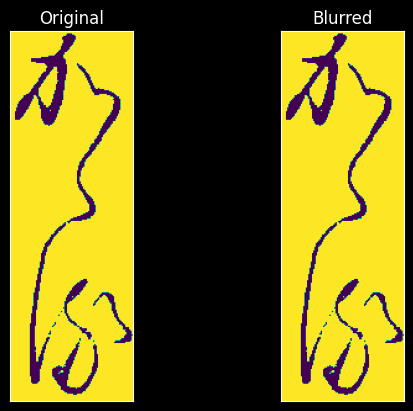

In [66]:
blur = cv2.blur(dst2, (1, 1))
plt.subplot(121), plt.imshow(dst2), plt.title("Original")
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(blur), plt.title("Blurred")
plt.xticks([]), plt.yticks([])
plt.show()

In [75]:
df.iloc[0].url[22:]

'0_001_0_1.jpg'

In [77]:
for url in tqdm(df.url):
    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, dst1 = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    blur = cv2.blur(dst1, (2, 2))
    cv2.imwrite(url[:20] + "3/" + url[22:], blur)

100%|██████████| 36880/36880 [00:44<00:00, 822.24it/s]


### Extract Features

In [78]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)


def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224, 224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1, 224, 224, 3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True, verbose=0)
    return features

2023-06-12 18:16:59.885274: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


553467096/553467096 [==============================] - 14s 0us/step


In [133]:
data = {}
p = r"nii_project/dataset/4/char_features.pkl"

# lop through each image in the dataset
for char in tqdm(chars):
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(
            "/Users/liyuxiao/Downloads/nii_project/dataset/4/" + char, model
        )
        data[char] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p, "wb") as file:
            pickle.dump(data, file)


# get a list of the filenames
filenames = np.array(list(data.keys()))

100%|██████████| 36880/36880 [1:30:29<00:00,  6.79it/s]      


In [134]:
with open(
    "/Users/liyuxiao/Downloads/nii_project/dataset/feature_data_4.pkl", "wb"
) as fp:
    pickle.dump(data, fp)
    print("dictionary saved successfully to file")

dictionary saved successfully to file


In [99]:
with open(
    "/Users/liyuxiao/Downloads/nii_project/dataset/feature_data.pkl", "rb"
) as handle:
    data = pickle.load(handle)

In [100]:
# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

(36880, 1, 4096)

In [101]:
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1, 4096)
feat.shape

(36880, 4096)

In [102]:
features = pd.DataFrame(data.items(), columns=["image_file", "features"])
features.features = features.features.apply(lambda x: x[0])

In [103]:
df_single_char_feature = pd.merge(df, features, on="image_file")
df_single_char_feature

data char  \
0      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...   その   
1      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    子   
2      {'char': 'むまこ', 'url': 'http://codh.rois.ac.jp...  むまこ   
3      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...  まては   
4      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...  はふれ   
...                                                  ...  ...   
36875  {'char': '国の', 'url': 'http://codh.rois.ac.jp/...   国の   
36876  {'char': '愽', 'url': 'http://codh.rois.ac.jp/s...    愽   
36877  {'char': '士', 'url': 'http://codh.rois.ac.jp/s...    士   
36878  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    共   
36879  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    の   

                                                     url         image_file  \
0      /Users/liyuxiao/Downloads/nii_project/dataset/...      0_001_0_1.jpg   
1      /Users/liyuxiao/Downloads/nii_project/dataset/...      1_001_0_1.jpg   
2      /Users/liyuxiao/Downloads/nii_project/dataset/...      2_001_0_1.jpg   
3      /Users/liyuxiao/Downloads/nii_project/dataset/...      3_001_0_1.jpg   
4      /Users/liyuxiao/Downloads/nii_project/dataset/...      4_001_0_1.jpg   
...                                                  ...                ...   
36875  /Users/liyuxiao/Downloads/nii_project/dataset/...  36875_001_9_1.jpg   
36876  /Users/liyuxiao/Downloads/nii_project/dataset/...  36876_001_9_1.jpg   
36877  /Users/liyuxiao/Downloads/nii_project/dataset/...  36877_001_9_1.jpg   
36878  /Users/liyuxiao/Downloads/nii_project/dataset/...  36878_001_9_1.jpg   
36879  /Users/liyuxiao/Downloads/nii_project/dataset/...  36879_001_9_1.jpg   

                                                features  
0      [0.8429354, 1.7519016, 3.0382361, 0.0, 1.70715...  
1      [1.4828894, 4.6046205, 1.1720784, 0.0, 0.0, 5....  
2      [0.23796302, 0.0, 2.7866492, 0.0, 0.0, 0.0, 0....  
3      [1.9867462, 1.2036382, 3.389811, 0.0, 0.0, 0.0...  
4      [4.506268, 1.7968079, 2.9978151, 0.0, 0.0, 0.0...  
...                                                  ...  
36875  [0.0, 3.3020818, 1.983189, 0.0, 0.0, 0.0, 3.82...  
36876  [3.4377332, 2.6483448, 3.7473426, 0.0, 0.0, 5....  
36877  [2.3860497, 0.0, 6.920697, 0.0, 0.0, 2.2187634...  
36878  [3.5111437, 0.3387832, 6.2902255, 0.0, 0.0, 2....  
36879  [2.1781428, 2.469665, 3.1132574, 0.0, 0.0, 4.0...  

[36880 rows x 5 columns]

### Dimensionality Reduction

#### TSNE + Kmeans

In [ ]:
len(np.unique(df_single_char[df_single_char.image_file.isin(features.image_file)].char))

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(list(features.features))

In [ ]:
kmeans = KMeans(n_clusters=1000, random_state=0).fit(tsne_results)
kmeans.labels_

In [ ]:
features["tsne-2d-one"] = tsne_results[:, 0]
features["tsne-2d-two"] = tsne_results[:, 1]
features["label"] = kmeans.labels_
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("viridis", as_cmap=True),
    data=features,
    alpha=0.3,
)

In [ ]:
for url in features[kmeans.labels_ == 8].image_file:
    display(Image(filename="/Users/liyuxiao/Downloads/nii_project/dataset/1/" + url))

#### UMAP+DBSCAN

In [108]:
# get a list of just the features
feat = np.array(list(data.values()))
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1, 4096)

features = pd.DataFrame(data.items(), columns=["image_file", "features"])
features.features = features.features.apply(lambda x: x[0])

df = pd.merge(df, features, on="image_file")
df["index"] = df.index
df

data char  \
0      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...   その   
1      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    子   
2      {'char': 'むまこ', 'url': 'http://codh.rois.ac.jp...  むまこ   
3      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...  まては   
4      {'url': 'http://codh.rois.ac.jp/soan/dataset/1...  はふれ   
...                                                  ...  ...   
36875  {'char': '国の', 'url': 'http://codh.rois.ac.jp/...   国の   
36876  {'char': '愽', 'url': 'http://codh.rois.ac.jp/s...    愽   
36877  {'char': '士', 'url': 'http://codh.rois.ac.jp/s...    士   
36878  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    共   
36879  {'url': 'http://codh.rois.ac.jp/soan/dataset/1...    の   

                                                     url         image_file  \
0      /Users/liyuxiao/Downloads/nii_project/dataset/...      0_001_0_1.jpg   
1      /Users/liyuxiao/Downloads/nii_project/dataset/...      1_001_0_1.jpg   
2      /Users/liyuxiao/Downloads/nii_project/dataset/...      2_001_0_1.jpg   
3      /Users/liyuxiao/Downloads/nii_project/dataset/...      3_001_0_1.jpg   
4      /Users/liyuxiao/Downloads/nii_project/dataset/...      4_001_0_1.jpg   
...                                                  ...                ...   
36875  /Users/liyuxiao/Downloads/nii_project/dataset/...  36875_001_9_1.jpg   
36876  /Users/liyuxiao/Downloads/nii_project/dataset/...  36876_001_9_1.jpg   
36877  /Users/liyuxiao/Downloads/nii_project/dataset/...  36877_001_9_1.jpg   
36878  /Users/liyuxiao/Downloads/nii_project/dataset/...  36878_001_9_1.jpg   
36879  /Users/liyuxiao/Downloads/nii_project/dataset/...  36879_001_9_1.jpg   

                                                features  index  
0      [0.8429354, 1.7519016, 3.0382361, 0.0, 1.70715...      0  
1      [1.4828894, 4.6046205, 1.1720784, 0.0, 0.0, 5....      1  
2      [0.23796302, 0.0, 2.7866492, 0.0, 0.0, 0.0, 0....      2  
3      [1.9867462, 1.2036382, 3.389811, 0.0, 0.0, 0.0...      3  
4      [4.506268, 1.7968079, 2.9978151, 0.0, 0.0, 0.0...      4  
...                                                  ...    ...  
36875  [0.0, 3.3020818, 1.983189, 0.0, 0.0, 0.0, 3.82...  36875  
36876  [3.4377332, 2.6483448, 3.7473426, 0.0, 0.0, 5....  36876  
36877  [2.3860497, 0.0, 6.920697, 0.0, 0.0, 2.2187634...  36877  
36878  [3.5111437, 0.3387832, 6.2902255, 0.0, 0.0, 2....  36878  
36879  [2.1781428, 2.469665, 3.1132574, 0.0, 0.0, 4.0...  36879  

[36880 rows x 6 columns]

/Users/liyuxiao/opt/anaconda3/envs/nii/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


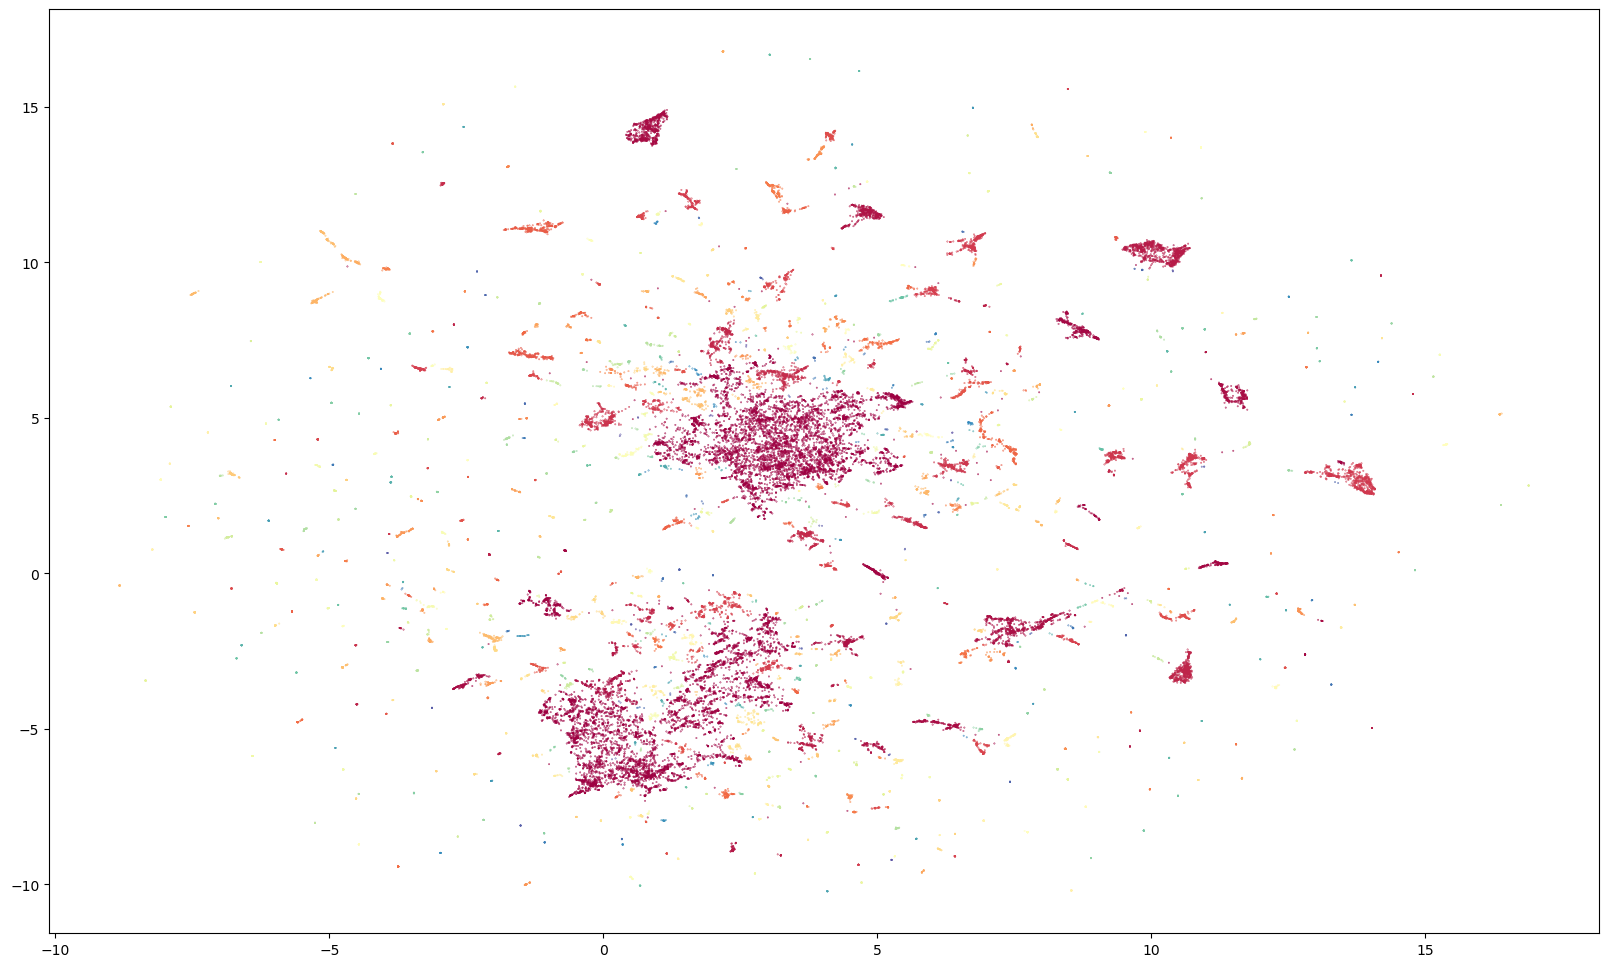

In [110]:
standard_embedding = umap.UMAP(
    n_neighbors=5, min_dist=0.0, n_components=2, random_state=42
).fit_transform(list(df.features))

clustering = DBSCAN(eps=0.1, min_samples=2).fit(standard_embedding)
clustering.labels_

plt.figure(figsize=(20, 12))
plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1,
    c=clustering.labels_,
    cmap="Spectral",
)

In [ ]:
counter = collections.Counter(clustering.labels_)
counter.most_common()

In [ ]:
from skimage.metrics import structural_similarity
import cv2
import numpy as np

# Load images
before = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + features[clustering.labels_ == 487].iloc[0].image_file
)
after = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + features[clustering.labels_ == 487].iloc[1].image_file
)

# Convert images to grayscale
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# Compute SSIM between the two images
(score, diff) = structural_similarity(before_gray, after_gray, full=True)
print("Image Similarity: {:.4f}%".format(score * 100))

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1]
# so we must convert the array to 8-bit unsigned integers in the range
# [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")
diff_box = cv2.merge([diff, diff, diff])

# Threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

mask = np.zeros(before.shape, dtype="uint8")
filled_after = after.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 40:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(before, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(after, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(diff_box, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.drawContours(mask, [c], 0, (255, 255, 255), -1)
        cv2.drawContours(filled_after, [c], 0, (0, 255, 0), -1)

cv2.imshow("before", before)
cv2.imshow("after", after)
cv2.imshow("diff", diff)
cv2.imshow("diff_box", diff_box)
cv2.imshow("mask", mask)
cv2.imshow("filled after", filled_after)
cv2.waitKey(0)  # close window when a key press is detected
cv2.destroyWindow("image")
cv2.waitKey(1)

In [ ]:
for url in df_single_char_feature[df_single_char_feature["char"] == "に"][
    clustering.labels_ == 4
].image_file:
    display(Image(filename="/Users/liyuxiao/Downloads/nii_project/dataset/1/" + url))